### Evaluating sequencing errors for synDNA reads

In [6]:
library(data.table)
library(reshape2)
library(RColorBrewer)
library(ggpmisc)
library(scales)

#### Run script inside directory with sequencing error files
#### To compute error we used the same strategy published by Tourlousse et al. 2017.

In [2]:
filesdir <- list.files(pattern = "*.sam_NM.txt$")

In [3]:
totalFreqTable <- NULL

for(i in 1:length(filesdir)){
    filename <- filesdir[i]
    Strand <- gsub("_paired.fq.*", "", gsub(".*_output_", "", filename))
    nmfile <- fread(filename, h=F)
    nmfile$ratio <- (nmfile$V4/nmfile$V3)*100
    nmfile$Sample <- rep(gsub("_L.*", "", filename), dim(nmfile)[1])
    nmfile$Strand <- rep(Strand, dim(nmfile)[1])
    colnames(nmfile) <- c("Plasmid", "PositionRef", "ReadLength", "Mismatches", "Ratio", "Sample", "Strand")
    totalFreqTable <- rbind(totalFreqTable, nmfile)
}

In [4]:
write.table(totalFreqTable, "totalFreqTable_NM.txt", quote = F, sep = "\t", row.names = F)

#### Calculating mean and standard deviation error call

In [7]:
std <- function(x) sd(x)/sqrt(length(x))
dfmean <- aggregate(x = totalFreqTable$Ratio, by = list(totalFreqTable$Plasmid, totalFreqTable$Sample, totalFreqTable$Strand), FUN = mean)
colnames(dfmean) <- c("Plasmid", "Sample", "Strand", "MeanRatio")
dfsd <- aggregate(x = totalFreqTable$Ratio, by = list(totalFreqTable$Plasmid, totalFreqTable$Sample, totalFreqTable$Strand), FUN = std)
colnames(dfsd) <- c("Plasmid", "Sample", "Strand", "StdRatio")

dfmeansd <- merge(dfmean, dfsd, by.x = c("Sample", "Plasmid", "Strand"), by.y = c("Sample", "Plasmid", "Strand"))
dfmeansd$Dilutions <- c(0,-1,-2,-3,-4,-4,-3,-2,-1,0,-4,-4,-3,-3,-2,-2,-1,-1,0,0,0,0,-1,-1,-2,-2,-3,-3,-4,-4)
write.table(dfmeansd, "dfmeansd_strand_dilutions2.csv", quote = F, sep = "\t", row.names = F)

In [11]:
dfalllibs <- read.delim("dfmeansd_strand_dilutions.csv", h=T)

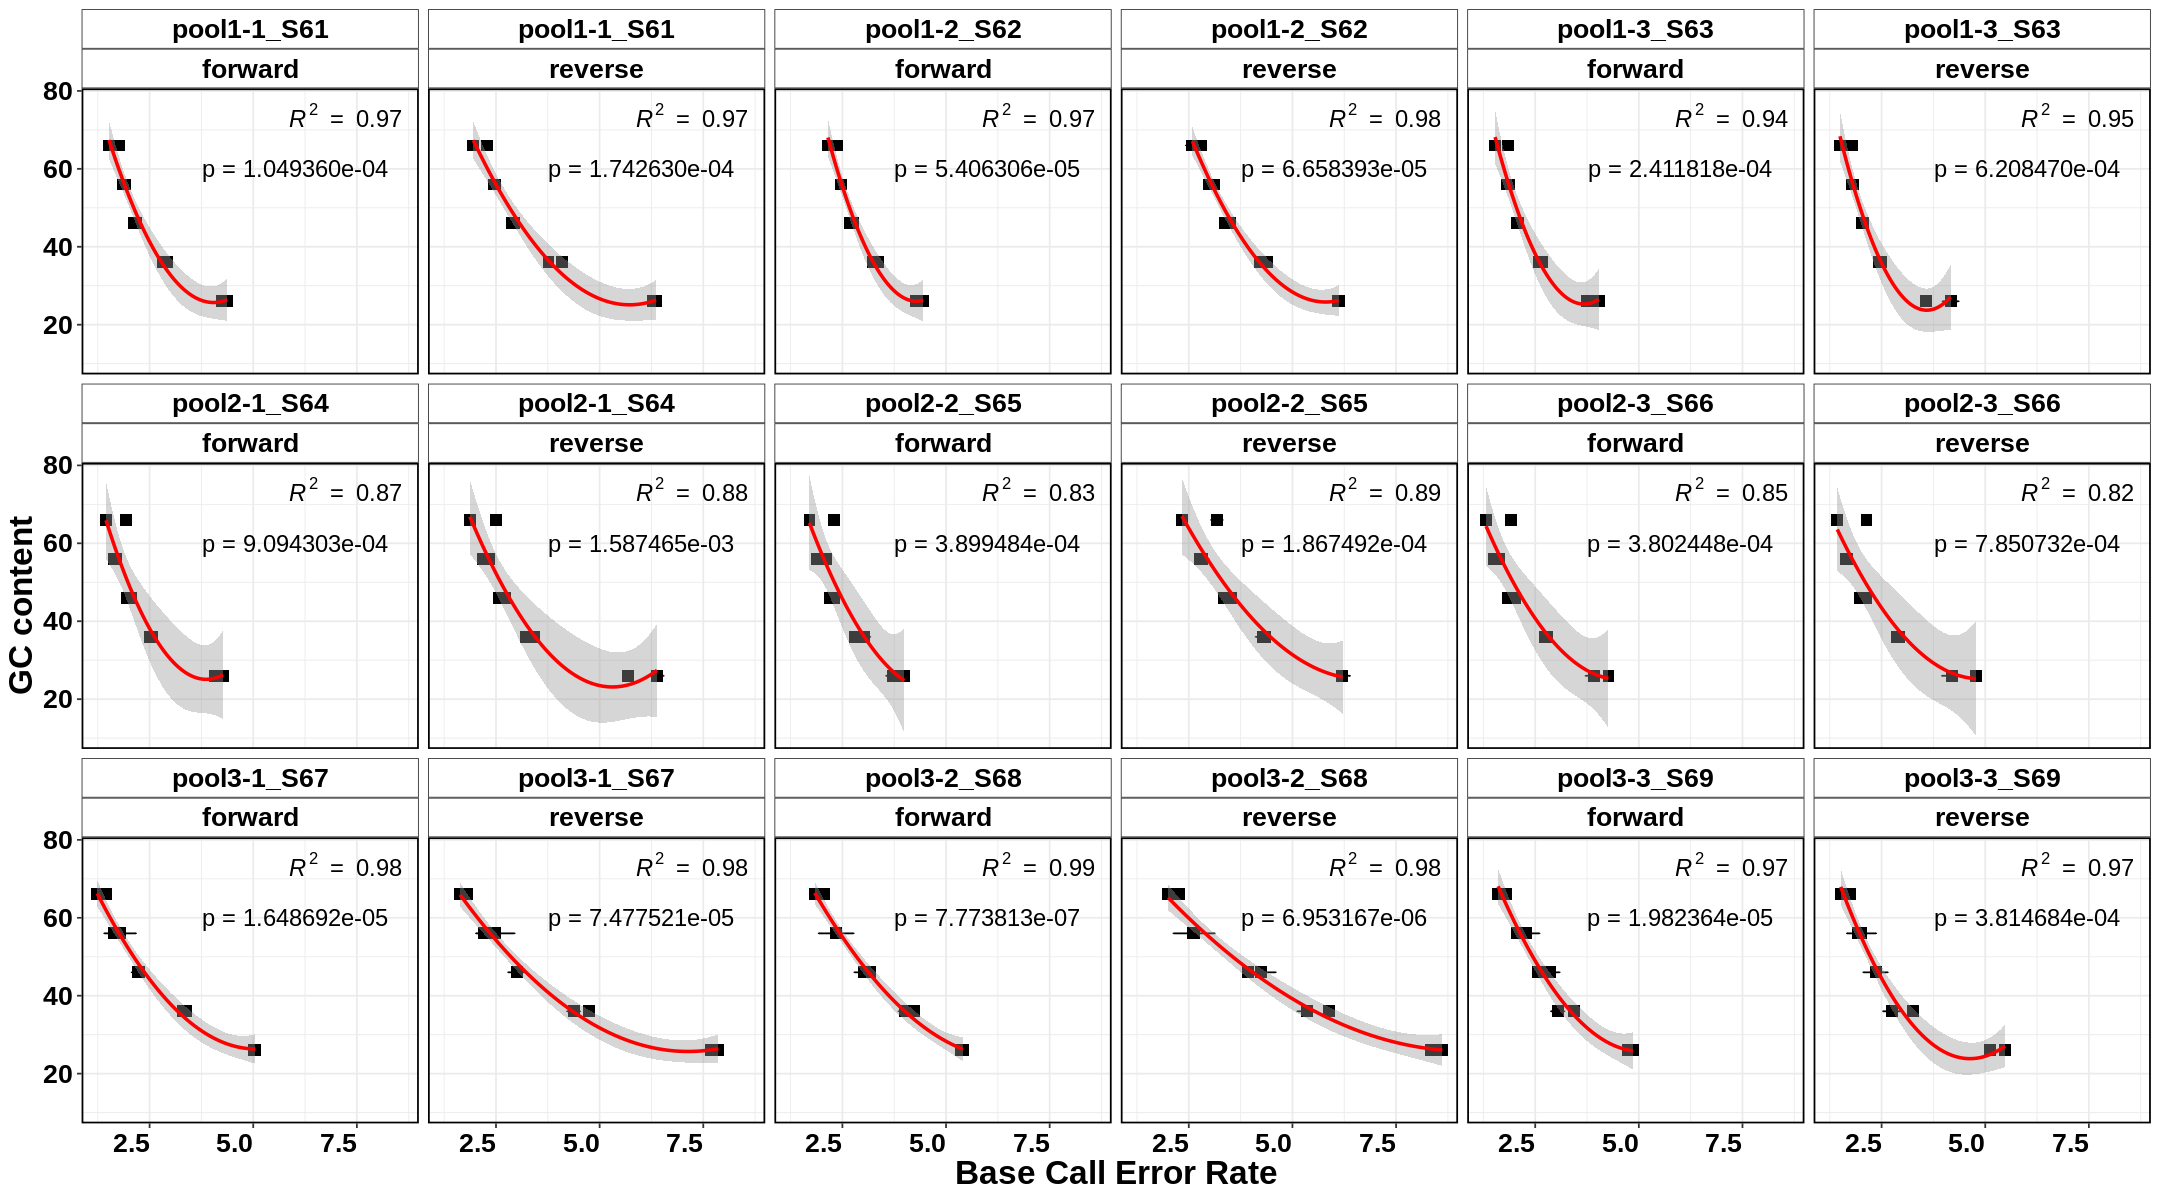

In [17]:
options(repr.plot.width=18, repr.plot.height=10)

ggplot(dfalllibs, aes(MeanRatio, GC)) +
  geom_point(shape = 15, size = 3) +
  geom_errorbar(aes(xmin=MeanRatio-StdRatio, xmax=MeanRatio+StdRatio), width=.3,position=position_dodge(0.05)) +
  facet_wrap(~ Sample+Strand, ncol = 6) +
  geom_smooth(method = "lm", color="red", formula = y~poly(x, 2)) +
  stat_poly_eq(formula = y~poly(x, 2), aes(label = ..rr.label..), 
               parse=TRUE, label.x.npc = "right",, size = 5) +
  stat_fit_glance(method = 'lm', geom = 'text', aes(label = paste0('p = ', format(..p.value.., 3))), 
                  label.x = 6, label.y = 60, size = 5) + 
  labs(y = "GC content", x = "Base Call Error Rate") +
  guides(colour = guide_legend(override.aes = list(size=5))) +
  theme_bw() + guides(fill=guide_legend(ncol=1))  +
  theme(panel.border = element_rect(colour = "black", fill=NA, size=1),
        axis.text.x = element_text(angle = 0, hjust = 1, vjust = 0.5, size = 16, face = "bold", colour = "black"),
        axis.text.y = element_text(angle = 0, size = 16, face = "bold", colour = "black"),
        axis.title=element_text(size=20, face = "bold", colour = "black"),
        strip.text.x = element_text(size = 16, face = "bold", colour = "black"),
        strip.background = element_rect(fill="white"),
        legend.title=element_blank())